In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pywt
import mne
from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# --- Step 1: Load EEG-MEG Dataset from MNE Sample ---
def load_dataset(data_dir="data/data/MNE-sample-data"):  # <-- Specifica il percorso desiderato
    # dataset = mne.datasets.sample.data_path(path=data_dir, verbose=True)
    raw = mne.io.read_raw_fif(data_dir + '/MEG/sample/sample_audvis_raw.fif', preload=True)
    raw.pick_types(meg=True, eeg=True, exclude='bads')
    return raw

# --- Step 2: Apply Continuous Wavelet Transform (CWT) ---
def apply_cwt(signal, wavelet='morl', scales=np.arange(1, 128)):
    coeffs, freqs = pywt.cwt(signal, scales, wavelet)
    return coeffs, freqs

# --- Step 3: Generate CWT Image using PIL ---
def generate_cwt_pil_image(time, freqs, cwtmatr, output_width=224, output_height=224):
    dpi = 100
    figsize = (output_width / dpi, output_height / dpi)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    pcm = ax.pcolormesh(time, freqs, np.abs(cwtmatr), shading='auto', cmap='viridis')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    canvas = FigureCanvas(fig)
    canvas.draw()
    img = np.array(canvas.buffer_rgba())[:, :, :3]
    pil_img = Image.fromarray(img)
    plt.close(fig)
    
    return pil_img

# --- Step 2: Visualize EEG and MEG Signals ---
def plot_eeg_meg_signals(raw, n_samples=1000):
    eeg_data, times = raw.get_data(picks="eeg", return_times=True)
    meg_data, _ = raw.get_data(picks="meg", return_times=True)

    print(f"times: {times}")
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    
    # Plot EEG
    axs[0].plot(times[:n_samples], eeg_data[0, :n_samples], label="EEG Channel 1", color='b')
    axs[0].set_ylabel("EEG Amplitude (µV)")
    axs[0].set_title("EEG Signal")
    axs[0].legend()
    
    # Plot MEG
    axs[1].plot(times[:n_samples], meg_data[0, :n_samples], label="MEG Channel 1", color='r')
    axs[1].set_ylabel("MEG Amplitude (fT)")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_title("MEG Signal")
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

def plot_signal(raw, plot_name = "EEG Channel 1", y_label = "EEG Amplitude (µV)", title = 'EEG Signal', color = 'blue'):

    times = np.linspace(0, 1, raw.shape[1])
    
    fig, axs = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
    
    # Plot EEG
    axs.plot(times, raw[0], label=plot_name, color=color)
    axs.set_ylabel(y_label)
    axs.set_xlabel("Time (s)")
    axs.set_title(title)
    axs.legend()
    
    plt.tight_layout()
    plt.show()


# --- Step 4: Test the pipeline ---
def process_and_visualize():
    raw = load_dataset()
    data, times = raw[:2, :1000]  # Get EEG & MEG signals for visualization
    
    signal = data[0]  # Example signal
    coeffs, freqs = apply_cwt(signal)
    
    img = generate_cwt_pil_image(times[:coeffs.shape[1]], freqs, coeffs)
    img.show()

In [3]:
raw = load_dataset()

Opening raw data file data/data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


times: [0.00000000e+00 1.66496011e-03 3.32992022e-03 ... 2.77710351e+02
 2.77712016e+02 2.77713681e+02]


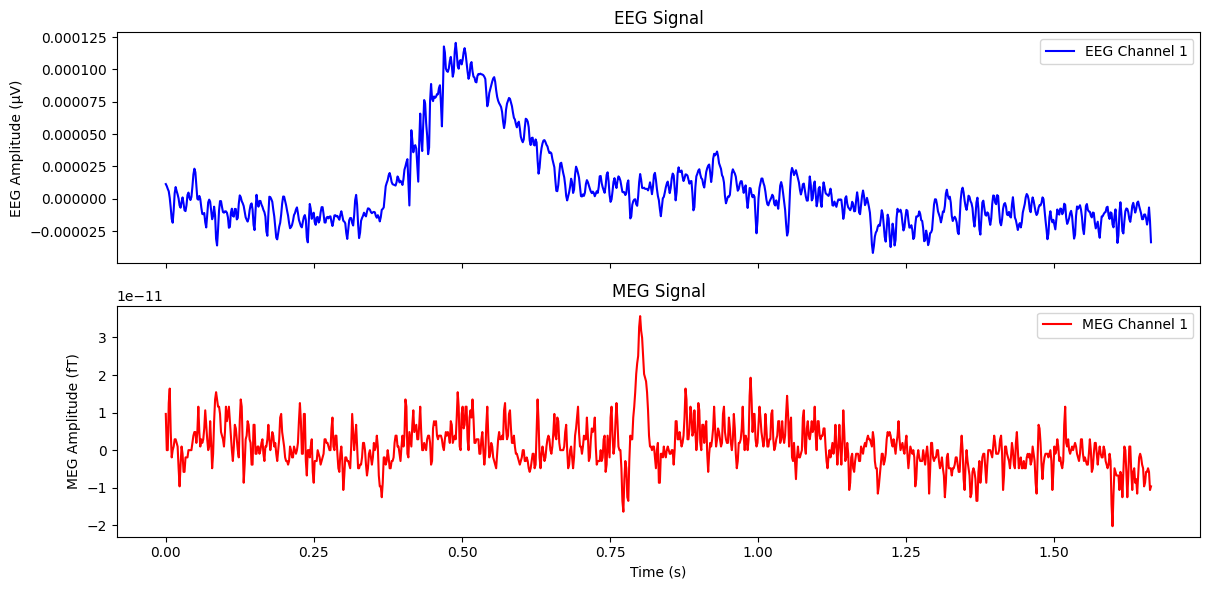

In [9]:
plot_eeg_meg_signals(raw)

In [13]:
# Seleziona solo EEG e MEG
eeg_channels = mne.pick_types(raw.info, eeg=True, meg=False)
meg_channels = mne.pick_types(raw.info, eeg=False, meg=True)

# Visualizza il numero di canali per ogni tipo
print(f"Numero di canali EEG: {len(eeg_channels)}")
print(f"Numero di canali MEG: {len(meg_channels)}")

Numero di canali EEG: 59
Numero di canali MEG: 305


In [10]:
eeg_data, times = raw.get_data(picks="eeg", return_times=True)
meg_data, _ = raw.get_data(picks="meg", return_times=True)

In [11]:
print(eeg_data.shape, meg_data.shape)

(59, 166800) (305, 166800)


In [ ]:
# Ottieni informazioni sui canali
info = raw.info

# Conta i canali per tipo
n_eeg = len(mne.pick_types(info, meg=False, eeg=True))
n_mag = len(mne.pick_types(info, meg='mag'))
n_grad = len(mne.pick_types(info, meg='grad'))

print(f"Numero di canali EEG: {n_eeg}")
print(f"Numero di magnetometri (MEG mag): {n_mag}")
print(f"Numero di gradiometri (MEG grad): {n_grad}")

In [ ]:
process_and_visualize()

# Testiamo divisione dataset

In [2]:
import numpy as np
import mne

# Carica il dataset
# dataset = mne.datasets.sample.data_path()
raw = mne.io.read_raw_fif("data/data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif", preload=True)

# Estrai EEG e MEG
sfreq = raw.info["sfreq"]  # Frequenza di campionamento
eeg_data = raw.get_data(picks="eeg")  # (59, 166800)
meg_data = raw.get_data(picks="meg")  # (305, 166800)

# Definiamo la finestra temporale (1 secondo = 600 campioni)
window_size = int(sfreq)  # 600 campioni per finestra
n_windows = eeg_data.shape[1] // window_size  # Numero di finestre totali

# Creiamo i dataset suddivisi in finestre
X_eeg = np.array(np.split(eeg_data[:, :n_windows * window_size], n_windows, axis=1))  # (n_windows, 59, 600)
Y_meg = np.array(np.split(meg_data[:, :n_windows * window_size], n_windows, axis=1))  # (n_windows, 305, 600)

print(f"EEG Windows Shape: {X_eeg.shape}")  # (n_windows, 59, 600)
print(f"MEG Windows Shape: {Y_meg.shape}")  # (n_windows, 305, 600)

Opening raw data file data/data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
EEG Windows Shape: (278, 60, 600)
MEG Windows Shape: (278, 306, 600)


In [4]:
print(X_eeg.shape, Y_meg.shape)

(278, 60, 600) (278, 306, 600)


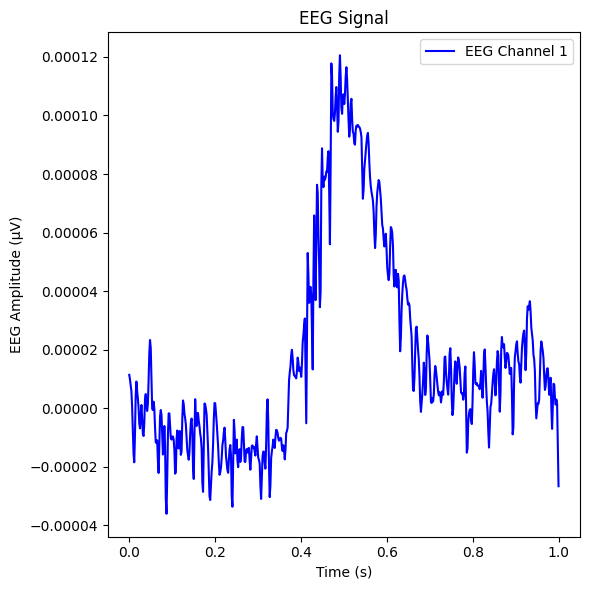

In [22]:
plot_signal(X_eeg[0], color = 'blue')

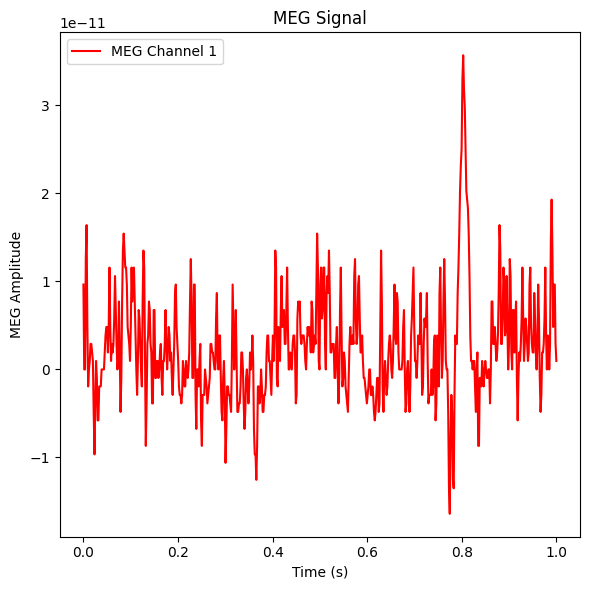

In [ ]:
plot_signal(Y_meg[0], plot_name = "MEG Channel 1", y_label = "MEG Amplitude", title = 'MEG Signal', color = 'red')